# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [44]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [45]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

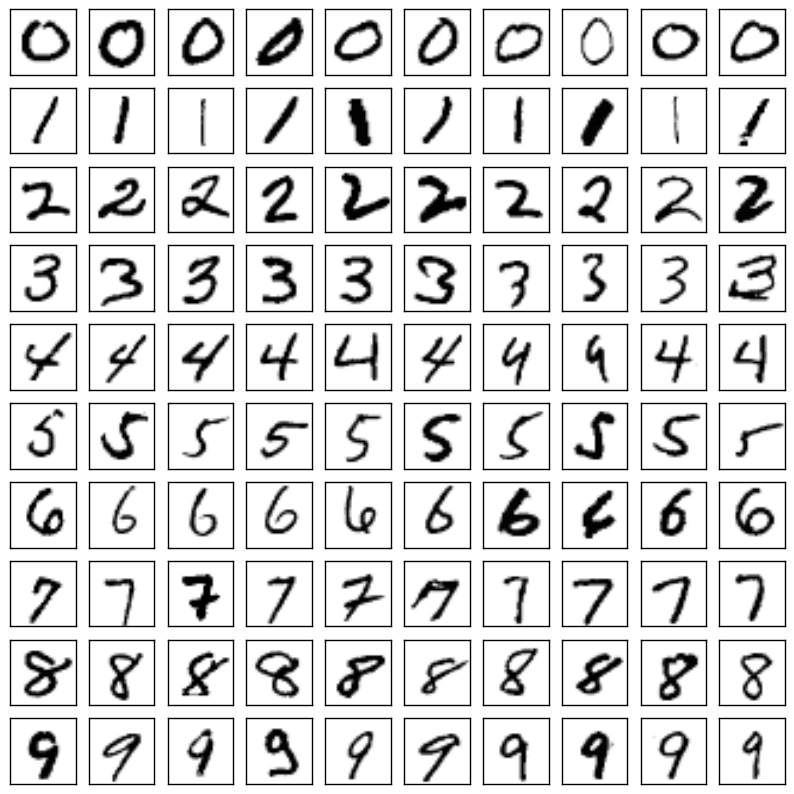

In [18]:
def P1(num_examples=10):
    
# matplotlib plotting grid of images
    
    # Initialize a new plot and set the size large enough so we can see each image.
    num_dig = len(np.unique(Y))
    #num_dig should be 10, because we have 0-9 digits
    plt.figure(figsize=(num_examples, num_dig))
    plt.rc('image', cmap='Greys')

    count = 0
    for digit in range(num_dig):
        #create an ndarray for each different digit
        digit_array = X[Y==digit][:num_examples]
        for index in range(num_examples):
            #Setup subplot
            ax = plt.subplot(num_dig, num_examples, count + 1)
            plt.setp(ax, xticks=(), yticks=())  
            #Parse and reshape associated matrix
            #I want the dimension to be 28 by 28 because data shape is (70000, 784)
            pixel = digit_array[index].reshape((28,28))
            plt.imshow(pixel)
            count += 1

### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [20]:
def P2(k_values):

    for k in k_values:
        # Create a k-Nearest-Neighbors model
        kNN_model = KNeighborsClassifier(n_neighbors=k)
        # Fit the model with the mini training set
        kNN_model.fit(mini_train_data, mini_train_labels)
        # Predict the dev set
        dev_predicted_labels = kNN_model.predict(dev_data)
        # Report accuracy for the dev set
        print "Accuracy using k =", k, ":", np.mean(dev_predicted_labels == dev_labels )

    # For k=1, show precision, recall, and F1 for each label.
        if k == 1:
            labels = np.unique(Y).astype(int).astype('S')
            print '\nPrecission, recall, and F1 for each digit when k = 1:'
            print classification_report(dev_labels, dev_predicted_labels, target_names = labels)
            
k_values = [1, 3, 5, 7, 9]
P2(k_values)

Accuracy using k = 1 : 0.888

Precission, recall, and F1 for each digit when k = 1:
             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

Accuracy using k = 3 : 0.878
Accuracy using k = 5 : 0.869
Accuracy using k = 7 : 0.865
Accuracy using k = 9 : 0.863


ANSWER: The most difficult digit is "9" because it has the lowest precision and f1-score. F1 is a weighted average between precision and recall. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def P3(train_sizes, accuracies):
    
    count = 0
    for size in train_sizes:
        #start the timer
        start_time = time.time()
        k=1
        kNN_model = KNeighborsClassifier(n_neighbors=k)
        # Fit the model with the training set
        kNN_model.fit(train_data[:size], train_labels[:size])
        # Predict the dev set
        dev_predicted_labels = kNN_model.predict(dev_data)
        #end the timer here since we are only measuring the time needed for prediction with different training size
        end_time = time.time()
        time_elipsed = end_time - start_time
        # Report accuracy for the dev set
        accuracy = np.mean(dev_predicted_labels == dev_labels)
        accuracies.append(accuracy)
        print "Training size of", size, ": Accuracy", accuracies[count], ", Time elapsed:", time_elipsed, "seconds."
        count += 1

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]

accuracies = []
P3(train_sizes, accuracies)

Training size of 100 : Accuracy 0.72 , Time elapsed: 0.179872989655 seconds.
Training size of 200 : Accuracy 0.786 , Time elapsed: 0.408411026001 seconds.
Training size of 400 : Accuracy 0.841 , Time elapsed: 0.712827205658 seconds.
Training size of 800 : Accuracy 0.884 , Time elapsed: 1.20154500008 seconds.
Training size of 1600 : Accuracy 0.902 , Time elapsed: 2.67242407799 seconds.
Training size of 3200 : Accuracy 0.926 , Time elapsed: 5.794672966 seconds.
Training size of 6400 : Accuracy 0.937 , Time elapsed: 10.5968489647 seconds.
Training size of 12800 : Accuracy 0.959 , Time elapsed: 28.272963047 seconds.
Training size of 25000 : Accuracy 0.97 , Time elapsed: 46.1764011383 seconds.


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Linear Regression predicts an accuracy: of  1.24307226036  with n = 60,000.
Taking the natural log transformation on the sample size predicts an accuracy: of 1.0338651375722188 with n = 60,000.
Taking the natural log transformation on the sample size predicts an accuracy: of 0.97851419544697282 with n = 60,000.


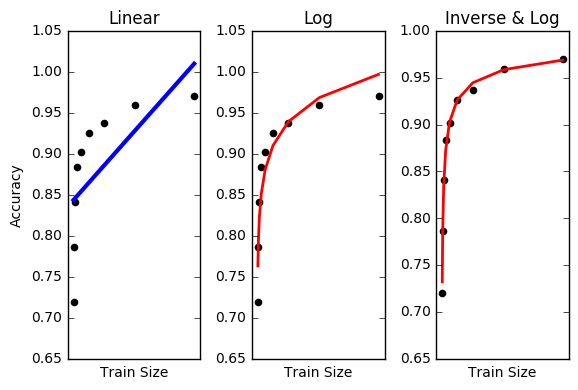

In [22]:
def P4():
    length = len(train_sizes)
    #linear regression model
    linearModel = LinearRegression()
    # Reshape train size vector and fit with accuracies
    linearModel.fit(np.reshape(train_sizes,(length,1)), accuracies)
    pred = linearModel.predict(60000)
    print "Linear Regression predicts an accuracy: of ", pred[0], " with n = 60,000."

    #make subplots for different regression models I've tried:
    axis = plt.subplot(1,3,1)
    plt.tight_layout()
    plt.setp(axis, xticks=())
    plt.scatter(train_sizes, accuracies, color='black')
    plt.plot(train_sizes, linearModel.predict(np.reshape(train_sizes,(length,1))), color='blue', linewidth=3)
    plt.xlabel("Train Size")
    plt.ylabel("Accuracy")
    plt.title('Linear')
    
    #linear regression without any transformation: 
    #1. linear regression without any transformation 
    logModel = LinearRegression()
    log_train_sizes = [np.log(size) for size in train_sizes]
    logModel.fit(np.reshape(log_train_sizes,(length,1)), accuracies)
    log_pred = logModel.predict(np.log(60000))
    print "Taking the natural log transformation on the sample size predicts an accuracy: of " + `log_pred[0]` + " with n = 60,000."
   
    #2. same linear regression with log transformtion on the x-axis 
    axis = plt.subplot(1,3,2)
    plt.tight_layout()
    plt.setp(axis, xticks=())
    plt.scatter(train_sizes, accuracies, color='black')  
    plt.plot(train_sizes, logModel.predict(np.reshape(log_train_sizes,(length,1))), color='red', linewidth=2)
    plt.xlabel("Train Size")
    plt.title('Log')
    
    #3. a new regression model that takes the log transformation on the x-axis and then cap it at 1
    new_logModel = LinearRegression()
    new_accuracies = [np.log(accuracy/(1-accuracy)) for accuracy in accuracies]
    new_logModel.fit(np.reshape(log_train_sizes,(length,1)), new_accuracies)
    new_log_pred = new_logModel.predict(np.log(60000))
    transform_pred = np.exp(new_log_pred)/(1+np.exp(new_log_pred))
    print "Taking the natural log transformation on the sample size predicts an accuracy: of " + `transform_pred[0]` + " with n = 60,000."
   
    axis = plt.subplot(1,3,3)
    plt.tight_layout()
    plt.setp(axis ,xticks=())
    plt.scatter(train_sizes, accuracies, color='black')
    yaxis = new_logModel.predict(np.reshape(log_train_sizes,(length,1)))
    transform_yaxis = np.exp(yaxis)/(1+np.exp(yaxis))
    plt.plot(train_sizes, transform_yaxis, color='red', linewidth=2)
    plt.xlabel("Train Size")
    plt.title('Inverse & Log')
    
    
P4()

ANSWER: Linear regression predicts an accuracy over 1, which is unreasonable. In order to make the prediction more reasonable when it comes to large training size, we can apply a log transformation. When I plot the data, it looks like training size and accuracy have a logarithmic relationship. So taking the natural log on the x-axis should give a more linear relationship. My transformation still predicts an accuracy over 1, but less than the linear regression before. Then I tried taking the inverse of the log transformation, which means the accuracy won't go above 1. From the third subplot, it looks like my third transformation fit the data the best, with an accuracy of 98%.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion Matrix is:
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

From the confusion matrix, the most confused pair of digits are 4s confused to be 9s.

Here are 10 examples when the true type is 4 and the predicted digit is 9:


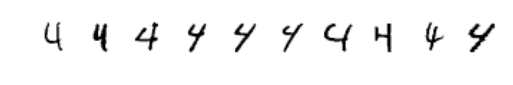

In [24]:

def P5():

    #Create a 1-NN Model
    NN_model = KNeighborsClassifier(n_neighbors=1)
    NN_model.fit(mini_train_data, mini_train_labels)
    pred = NN_model.predict(dev_data)
    # Create the confusion matrix for the dev data
    confusion = confusion_matrix(dev_labels, pred)
    print "Confusion Matrix is:\n", confusion
    print "\nFrom the confusion matrix, the most confused pair of digits are 4s confused to be 9s.\n"
    print "Here are 10 examples when the true type is 4 and the predicted digit is 9:"
    i = 0
    count = 0
    
    # Show 10 examples for when true label is 4 and it is predicted at 9
    while count < 10:
        if dev_labels[i] == 4 and pred[i] == 9:
            pix = np.reshape(dev_data[i,], (28,28))
            plt.subplot(1, 10, count+1)
            plt.imshow(pix, cmap = 'Greys')
            plt.axis('off')
            count += 1
        i += 1
P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [26]:
def P6():
    #I implemented my Gaussian blur by his description and formula
    #http://www.pixelstech.net/article/1353768112-Gaussian-Blur-Algorithm
    def blur(data, sigma=1):  
        
        weights = np.zeros((3, 3))
        total_weight = 0
        for i in range (-1, 2):
            for j in range (-1, 2):
                weights[i+1][j+1] = (1/(2 * np.pi * sigma**2))*np.exp(-1 * (i**2 + j**2)/(2 * sigma**2))
                total_weight += weights[i+1][j+1]
        # Normalize weights
        for i in range (0, 3):
            for j in range(0, 3):
                weights[i][j] = weights[i][j]/total_weight
            
        blur_data = np.zeros(data.shape)
        # For each row in data
        for i in range(data.shape[0]):
            # Reshape to 28x28 matrix
            pix = np.reshape(data[i], (28,28))
            blur_pix = np.zeros((28, 28))
            for j in range(1, 27):
                for k in range(1, 27):
                    for l in range(-1, 2):
                        for m in range(-1, 2):
                            # Add weighted value to blurred matrix
                            blur_pix[j][k] += pix[j+l][k+m] * weights[l+1][m+1]
            # Reshape blurred matrix to match original data shape
            blur_data[i] = np.reshape(blur_pix, (1, 784))
        return blur_data        

    def Model_Accuracy(train_data, train_label, test_data, test_label):
        # Setup classifier and check accuracy for each case
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(train_data, train_label) 
        predictions = model.predict(test_data)             
        print "accuracy = ", np.mean(predictions == test_label), "\n"

#preprocess the training data but not the dev data

    b_mini_train_data = blur(mini_train_data)
    print "Preprocess the training data gives an"
    Model_Accuracy(b_mini_train_data, mini_train_labels, dev_data, dev_labels)

#preprocess the dev data but not the training data

    b_dev_data = blur(dev_data)
    print "Preprocess the dev data gives an"
    Model_Accuracy(mini_train_data, mini_train_labels, b_dev_data, dev_labels)

#preprocess both training and dev data

    print "Preprocess both the training and the dev data gives an"
    Model_Accuracy(b_mini_train_data, mini_train_labels, b_dev_data, dev_labels)

P6()

Preprocess the training data gives an
accuracy =  0.907 

Preprocess the dev data gives an
accuracy =  0.876 

Preprocess both the training and the dev data gives an
accuracy =  0.902 



ANSWER: After implementing the Gaussian blur, the accuracy of the prediction increase from earlier. Out of the three different approaches, I find that preprocessing the training data gives the best accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [46]:
def P7():
    #tried first by preprocessing the data
    binarized_train_data = np.copy(mini_train_data)
    binarized_train_data[mini_train_data <= 0.5] = 0
    binarized_train_data[mini_train_data  > 0.5] = 1
    
    bernoulli_1 = BernoulliNB()
    bernoulli_1.fit(binarized_train_data, mini_train_labels)
    print "Bernoulli NB with preprocessed data, Accuracy:", bernoulli_1.score(dev_data, dev_labels)

    #Then I try to find the best binarize argument that would maximize accuracy    
    score_array=np.zeros(100)
    binarize_value =  [x / 100.0 for x in range(1, 100)]
    i=0
    for bin in [x / 100.0 for x in range(1, 100)]:
        bern = BernoulliNB(binarize=bin)
        bern.fit(mini_train_data, mini_train_labels)
        score_array[i] = bern.score(dev_data, dev_labels)
        i = i + 1
    print "The binarize argument value that maximize accuracy is", binarize_value[np.argmax(score_array)]
    print "Accuracy at this binarize value is", score_array[np.argmax(score_array)]
    
    
    multinomial = MultinomialNB()
    # preprocess data to convert to 0=white, 1=grey, 2=black
    mapped_train_data = np.copy(mini_train_data)
    mapped_train_data[mini_train_data < 0.33] = 0
    mapped_train_data[np.logical_and(mini_train_data >= 0.33, mini_train_data <= 0.67)] = 1
    mapped_train_data[mini_train_data  > 0.67] = 2
    
    multinomial.fit(mapped_train_data , mini_train_labels)
    print "Multinomial accuracy with preprocessed data:", multinomial.score(dev_data, dev_labels)

P7()

Bernoulli NB with preprocessed data, Accuracy: 0.796
The binarize argument value that maximize accuracy is 0.37
Accuracy at this binarize value is 0.823
Multinomial accuracy with preprocessed data: 0.797


ANSWER: Multi-class version did not improve the result. The Bernoulli NB has a maximum accuracy of 82.5% while the Multinomial NB has a accuracy of 79.% with the values I chose to classify the pixels as white, grey or black. The binary class model performed better because it increased the probablity of where there should have been data in that pixel. With the multiclass model, the new, 'grey', values are less likely to be interpreted as 'on'.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [35]:
def P8(alphas):
    #Bernoulli Model with the optimal binarize argument from P7
    bernoulli = BernoulliNB(binarize=0.41)
    grid_search = GridSearchCV(bernoulli, alphas)
    grid_search.fit(mini_train_data, mini_train_labels) # fit grid search
    
    # Run Bernoulli NB for alpha = 0
    Bernoulli_0 = BernoulliNB(binarize=0.41, alpha=0.0)
    Bernoulli_0.fit(mini_train_data, mini_train_labels)
    print "Bernoulli NB model accuracy with alpha = 0:", Bernoulli_0.score(train_data, train_labels)

    return grid_search

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print "The best value for alpha is ", nb.best_params_
print "The accuracy of the Bernoulli NB model with this alpha is:",nb.best_score_


Bernoulli NB model accuracy with alpha = 0: 0.0989166666667
The best value for alpha is  {'alpha': 0.001}
The accuracy of the Bernoulli NB model with this alpha is: 0.82


ANSWER: Using GridSearchCV, I found the best value for alpha to be 0.01. The accuracy of the model when alpha=0 is 0.099, which is very small. This is expected because if we set alpha equal to be 0, we're saying that there is no smoothing.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

Gaussian NB model accuracy:  0.621
theta: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
sigma:  [[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]]

 Notice sigma and theta values are all really small and not normally 

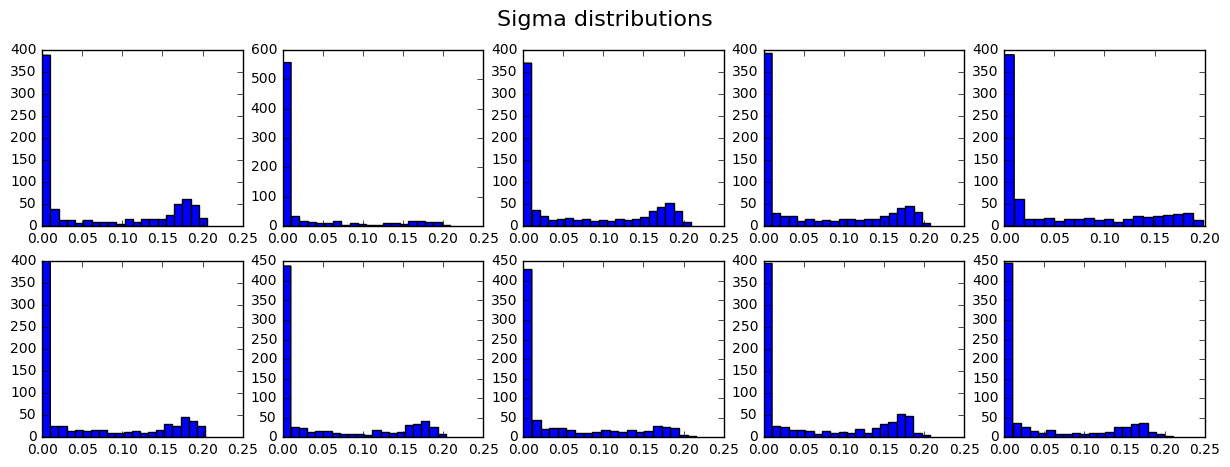

In [56]:
def P9():
    
    gaussian = GaussianNB()
    gaussian.fit(mini_train_data, mini_train_labels)
    print "Gaussian NB model accuracy: ", gaussian.score(dev_data, dev_labels) 
    print 'theta: ' + str(gaussian.theta_)
    print "sigma: ", str(gaussian.sigma_)
    
    #Here I plot the general distribution of sigma to get a sense that it is not normally distributed
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Sigma distributions', fontsize=16)
    for i in range(1,11):
        plt.subplot(2,5,i)
        plt.hist(gaussian.sigma_[i-1], bins=20)
    print "\n Notice sigma and theta values are all really small and not normally distributed."
    print "One of the assumption of Gaussian is that the data follows a normal distribution, \n which does not look like the case we have here.\n"
    
    # Adding random noise to the training data
    new_mini_train_data = np.zeros(mini_train_data.shape)
    for i in range(mini_train_data.shape[0]):
        for j in range(mini_train_data.shape[1]):
            # the 0.3 constant here is from trial and error optimizing accuracy
            new_mini_train_data[i][j] = mini_train_data[i][j] + 0.3 * np.random.rand()
           
    gaussian_withnoise = GaussianNB()
    gaussian_withnoise.fit(new_mini_train_data, mini_train_labels)
    print "Gaussian NB model accuracy: ", gaussian_withnoise.score(dev_data, dev_labels)  

    
gnb = P9()

ANSWER: The sigma is so small here which means that a small deviation from the average will mean that data point is not considered in that category. From the histogram, we can see that sigma is not normally distributed. I added a random noise to each pixel of the data to try to improve the result. It brings the accuracy from 62.1% to 81.7%. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

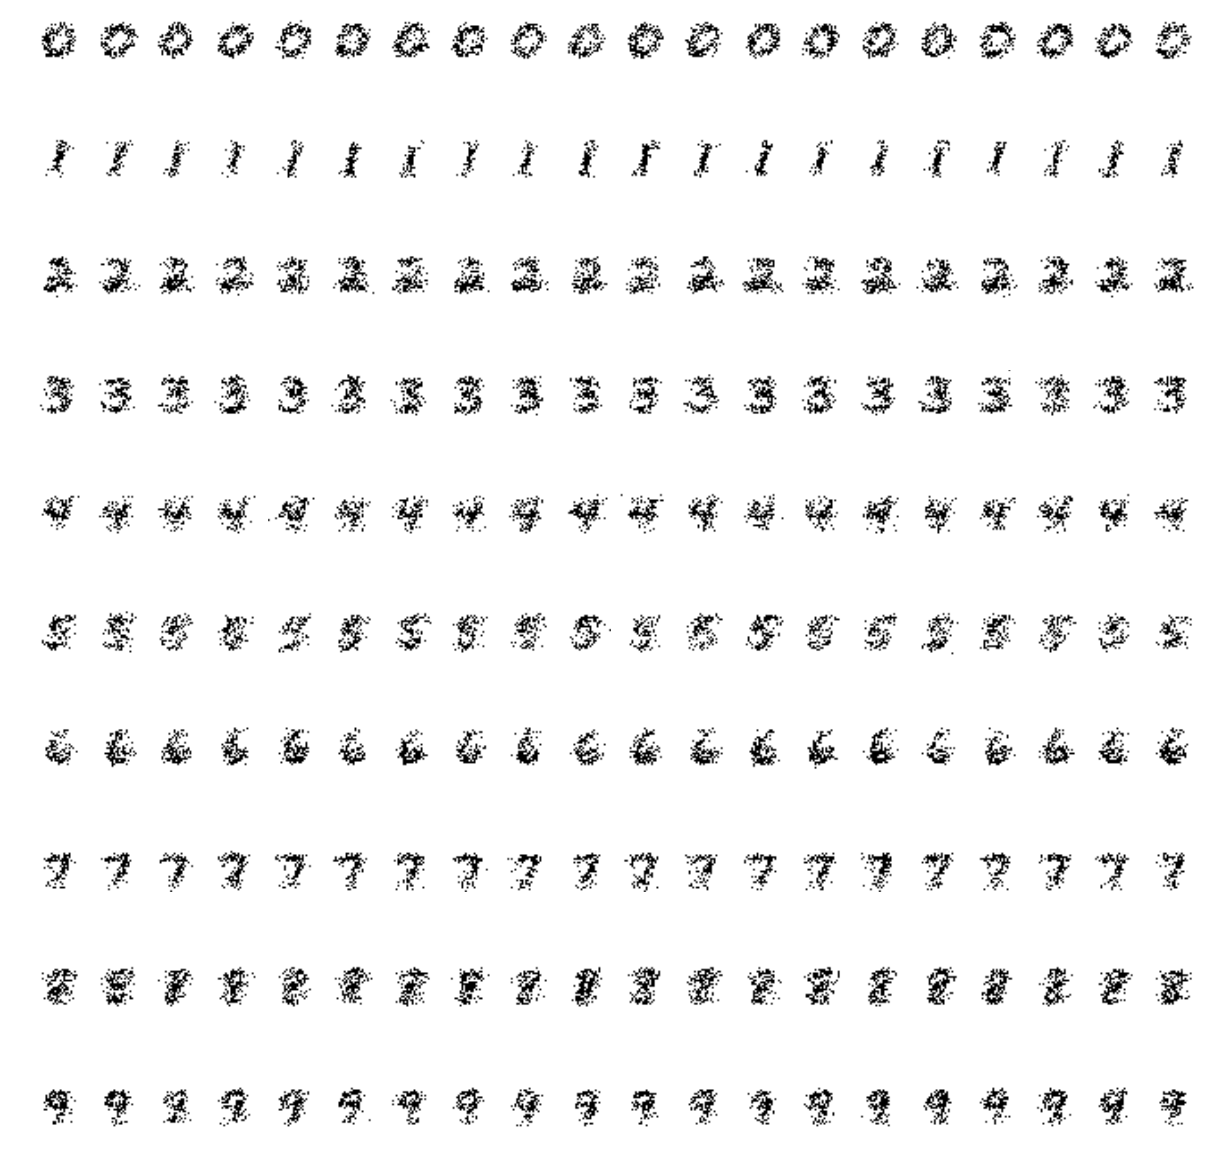

In [48]:
def P10(num_examples):

    # Train Bernoulli NB
    # Using the optimal binarize and alpha argument found from previous steps
    bernoulli = BernoulliNB(binarize = 0.41, alpha = 0.01)
    bernoulli.fit(mini_train_data, mini_train_labels)
    
    fig = plt.figure(figsize=(15, 15))
    # Generate num_examples examples per digit
    for i in range(num_examples):
        for j in range(10):
            # Generate random array from a uniform distribution 
            #The data shape is (70000, 784) from before
            random_array = np.random.rand(784)
            #Reshape the dimension to be 28 by 28
            #feature_log_prob_ = Empirical log probability of features given a class
            pixel = np.reshape([np.exp(bernoulli.feature_log_prob_)[j] > random_array], (28,28))
            plt.subplot(10, num_examples, j * num_examples + i + 1)
            plt.imshow(pixel, cmap = 'Greys')
            plt.axis('off')

P10(20)

ANSWER: The generated digits are fuzzier than the training digits, but the general shape is there. The model did a relatively good job of deciding which pixels should be on for each digit. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [49]:
def P11(buckets, correct, total):
    
    bernoulli = BernoulliNB(binarize = 0.5, alpha = 0.01)
    bernoulli.fit(mini_train_data, mini_train_labels)
    dev_predicted_labels = bernoulli.predict(dev_data)
    posterior = bernoulli.predict_proba(dev_data)
   
    correct_pred = np.zeros(len(dev_labels))
    # Loop through each posterior bucket and then count # of correct and total for each bucket
    for count in range(len(dev_labels)):
        # Find bucket that has maximum posterior for each prediction
        correct_pred[count] = np.argmax(posterior[count]) == dev_labels[count]  
        j = 0
        for i in buckets:
            # Update correct and total coutners
            if np.max(posterior[count]) <= i:                
                correct[j] += correct_pred[count]
                total[j] += 1
            else:
                j += 1
    
buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total = 240    accuracy = 0.200
p(pred) <= 0.9990000000000    total = 602    accuracy = 0.465
p(pred) <= 0.9999900000000    total = 510    accuracy = 0.612
p(pred) <= 0.9999999000000    total = 290    accuracy = 0.690
p(pred) <= 0.9999999990000    total = 244    accuracy = 0.754
p(pred) <= 0.9999999999900    total = 219    accuracy = 0.877
p(pred) <= 0.9999999999999    total = 150    accuracy = 0.840
p(pred) <= 1.0000000000000    total = 532    accuracy = 0.953


ANSWER: My Naive Bayes model is weakly calibrated because there is a positive correlation between the posterior  and accuracy. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [14]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()